### **BÁO CÁO ĐỒ ÁN CUỐI KỲ**
# DỮ LIỆU LỚN - IS405.O11.HTCL
# ***ĐỀ TÀI: DỰ ĐOÁN NĂNG LỰC HỌC TẬP VÀ ĐIỂM THI CUỐI NĂM CỦA HỌC SINH***
# Danh sách thành viên:
1. Đỗ Huỳnh Mỹ Tâm - 20520746
2. Nguyễn Phạm Thanh Phong - 21522458
3. Đinh Thị Tú Uyên - 20522139
4. Nguyễn Công Thành - 20521918

## Thuật toán sử dụng: Linear Regression

### Giới thiệu về tập dữ liệu: Bộ dữ liệu...
### Data Source: https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics?resource=download

# 1. Pre-installation


In [ ]:
!pip install pyspark

In [ ]:
!pip install findspark

##2. Khởi tạo Spark Session & Spark Context

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("LinearRegressionGD").getOrCreate()

In [ ]:
spark

In [ ]:
sc = spark.sparkContext

##3. Import Các thư viện cần thiết

In [ ]:
# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from plotnine import *

from pyspark.sql import functions as f
from pyspark.sql.types import FloatType

import json

##4. Load dữ Liệu từ file csv

In [ ]:
df_math = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .option("escape", '"')\
    .option("na_values", ["", " ", "N/A", "NA"])\
    .load("student_math_clean.csv")

df_math.cache()
df_math.count()

395

In [ ]:
df_portu = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .option("escape", '"')\
    .option("na_values", ["", " ", "N/A", "NA"])\
    .load("student_portuguese_clean.csv")

df_portu.cache()
df_portu.count()

649

In [ ]:
df_math = df_math.drop("student_id")
df_portu = df_portu.drop("student_id")

In [ ]:
df_uni = df_math.union(df_portu)

In [ ]:
temp_file = "temp_combined.csv"
df_uni.write.csv(temp_file, mode="overwrite", header=True)

In [ ]:
total_intances_df_uni = df_uni.count()
print(total_intances_df_uni)

1044


##5. Xem các thông số của dữ liệu

###5.1 Xem dataframe & schema

In [ ]:
# Hiển thị thông tin dữ liệu
num_rows = df_uni.count()
print(f"Số dòng: {num_rows}")
num_columns = len(df_uni.columns)
print(f"Số cột: {num_columns}")

display(df_uni)
df_uni.printSchema()

Số dòng: 1044
Số cột: 33


DataFrame[school: string, sex: string, age: int, address_type: string, family_size: string, parent_status: string, mother_education: string, father_education: string, mother_job: string, father_job: string, school_choice_reason: string, guardian: string, travel_time: string, study_time: string, class_failures: int, school_support: string, family_support: string, extra_paid_classes: string, activities: string, nursery_school: string, higher_ed: string, internet_access: string, romantic_relationship: string, family_relationship: int, free_time: int, social: int, weekday_alcohol: int, weekend_alcohol: int, health: int, absences: int, grade_1: int, grade_2: int, final_grade: int]

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address_type: string (nullable = true)
 |-- family_size: string (nullable = true)
 |-- parent_status: string (nullable = true)
 |-- mother_education: string (nullable = true)
 |-- father_education: string (nullable = true)
 |-- mother_job: string (nullable = true)
 |-- father_job: string (nullable = true)
 |-- school_choice_reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- travel_time: string (nullable = true)
 |-- study_time: string (nullable = true)
 |-- class_failures: integer (nullable = true)
 |-- school_support: string (nullable = true)
 |-- family_support: string (nullable = true)
 |-- extra_paid_classes: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery_school: string (nullable = true)
 |-- higher_ed: string (nullable = true)
 |-- internet_access: string (nullable = true)
 |-- romantic_relationship: stri

###5.2 Xem các giá trị Distinct theo số lần

In [ ]:
for column in df_uni.columns:
  df_uni.groupBy(column).count().show()

+------+-----+
|school|count|
+------+-----+
|    MS|  272|
|    GP|  772|
+------+-----+

+---+-----+
|sex|count|
+---+-----+
|  F|  591|
|  M|  453|
+---+-----+

+---+-----+
|age|count|
+---+-----+
| 22|    2|
| 16|  281|
| 20|    9|
| 19|   56|
| 15|  194|
| 17|  277|
| 21|    3|
| 18|  222|
+---+-----+

+------------+-----+
|address_type|count|
+------------+-----+
|       Urban|  759|
|       Rural|  285|
+------------+-----+

+--------------------+-----+
|         family_size|count|
+--------------------+-----+
|      Greater than 3|  738|
|Less than or equa...|  306|
+--------------------+-----+

+---------------+-----+
|  parent_status|count|
+---------------+-----+
|          Apart|  121|
|Living together|  923|
+---------------+-----+

+--------------------+-----+
|    mother_education|count|
+--------------------+-----+
|    5th to 9th grade|  289|
|                none|    9|
| secondary education|  238|
|primary education...|  202|
|    higher education|  306|
+-----------

###5.3 Xem các giá trị distinct theo tần suất xuất hiện

In [ ]:
from pyspark.sql import functions as F

for column in df_uni.columns:
    df_distinct_col = df_uni.groupBy(column).count()
    df_distinct_col = df_distinct_col.withColumn("percentage", F.round((F.col("count") / total_intances_df_uni) * 100, 2))
    df_distinct_col.show()

+------+-----+----------+
|school|count|percentage|
+------+-----+----------+
|    MS|  272|     26.05|
|    GP|  772|     73.95|
+------+-----+----------+

+---+-----+----------+
|sex|count|percentage|
+---+-----+----------+
|  F|  591|     56.61|
|  M|  453|     43.39|
+---+-----+----------+

+---+-----+----------+
|age|count|percentage|
+---+-----+----------+
| 22|    2|      0.19|
| 16|  281|     26.92|
| 20|    9|      0.86|
| 19|   56|      5.36|
| 15|  194|     18.58|
| 17|  277|     26.53|
| 21|    3|      0.29|
| 18|  222|     21.26|
+---+-----+----------+

+------------+-----+----------+
|address_type|count|percentage|
+------------+-----+----------+
|       Urban|  759|      72.7|
|       Rural|  285|      27.3|
+------------+-----+----------+

+--------------------+-----+----------+
|         family_size|count|percentage|
+--------------------+-----+----------+
|      Greater than 3|  738|     70.69|
|Less than or equa...|  306|     29.31|
+--------------------+-----+------

###5.4 Mô tả dữ liệu

In [ ]:
df_uni.describe().show()

+-------+------+----+------------------+------------+--------------------+---------------+-------------------+-------------------+----------+----------+--------------------+--------+-------------+------------+-------------------+--------------+--------------+------------------+----------+--------------+---------+---------------+---------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|school| sex|               age|address_type|         family_size|  parent_status|   mother_education|   father_education|mother_job|father_job|school_choice_reason|guardian|  travel_time|  study_time|     class_failures|school_support|family_support|extra_paid_classes|activities|nursery_school|higher_ed|internet_access|romantic_relationship|family_relationship|         free_time|            social|   weekday_alcohol|   weekend_alcohol|         

###5.5 Tiến hành factorize cho các cột có data không phải ở dạng số

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from itertools import chain

mappings = {}

# Iterate over each column
for column in df_uni.columns:
    # Check if the column is not of integer type
    if not isinstance(df_uni.schema[column].dataType, T.IntegerType):
        # Extract unique values and enumerate them
        unique_values = df_uni.select(column).distinct().rdd.flatMap(lambda x: x).collect()
        mapping = {val: i for i, val in enumerate(unique_values)}
        mappings[column] = mapping

        # Create the mapping expression
        mapping_expr = F.create_map([F.lit(x) for x in chain(*mapping.items())])

        # Create a new column with factorized values
        factorized_column = column + '_factorized'
        df_uni = df_uni.withColumn(factorized_column, mapping_expr[df_uni[column]])

        # Optionally, you can drop the original non-integer column if you want
        df_uni = df_uni.drop(column)

print("Mappings:", mappings)
df_uni.show()


Mappings: {'school': {'MS': 0, 'GP': 1}, 'sex': {'F': 0, 'M': 1}, 'address_type': {'Urban': 0, 'Rural': 1}, 'family_size': {'Greater than 3': 0, 'Less than or equal to 3': 1}, 'parent_status': {'Apart': 0, 'Living together': 1}, 'mother_education': {'5th to 9th grade': 0, 'none': 1, 'secondary education': 2, 'primary education (4th grade)': 3, 'higher education': 4}, 'father_education': {'5th to 9th grade': 0, 'none': 1, 'secondary education': 2, 'primary education (4th grade)': 3, 'higher education': 4}, 'mother_job': {'at_home': 0, 'teacher': 1, 'other': 2, 'health': 3, 'services': 4}, 'father_job': {'at_home': 0, 'teacher': 1, 'other': 2, 'health': 3, 'services': 4}, 'school_choice_reason': {'reputation': 0, 'course': 1, 'other': 2, 'home': 3}, 'guardian': {'father': 0, 'mother': 1, 'other': 2}, 'travel_time': {'>1 hour': 0, '15 to 30 min.': 1, '<15 min.': 2, '30 min. to 1 hour': 3}, 'study_time': {'5 to 10 hours': 0, '>10 hours': 1, '<2 hours': 2, '2 to 5 hours': 3}, 'school_suppor

#### Xem kết quả sau khi mapping

In [ ]:
import json
# Convert the Python object to a JSON string
json_string = json.dumps(mappings, indent=4)

# Print the JSON string
print(json_string)

{
    "school": {
        "MS": 0,
        "GP": 1
    },
    "sex": {
        "F": 0,
        "M": 1
    },
    "address_type": {
        "Urban": 0,
        "Rural": 1
    },
    "family_size": {
        "Greater than 3": 0,
        "Less than or equal to 3": 1
    },
    "parent_status": {
        "Apart": 0,
        "Living together": 1
    },
    "mother_education": {
        "5th to 9th grade": 0,
        "none": 1,
        "secondary education": 2,
        "primary education (4th grade)": 3,
        "higher education": 4
    },
    "father_education": {
        "5th to 9th grade": 0,
        "none": 1,
        "secondary education": 2,
        "primary education (4th grade)": 3,
        "higher education": 4
    },
    "mother_job": {
        "at_home": 0,
        "teacher": 1,
        "other": 2,
        "health": 3,
        "services": 4
    },
    "father_job": {
        "at_home": 0,
        "teacher": 1,
        "other": 2,
        "health": 3,
        "services": 4
    },


In [ ]:
target_column = "final_grade"

# Compute and print the correlation between each column and the target column
for column in df_uni.columns:
    if column != target_column:
        correlation = df_uni.stat.corr(column, target_column)
        print(f"Correlation between {column} and {target_column}: {correlation}")

Correlation between age and final_grade: -0.12528243256717775
Correlation between class_failures and final_grade: -0.38314527971827445
Correlation between family_relationship and final_grade: 0.05446105940363294
Correlation between free_time and final_grade: -0.06488967904803611
Correlation between social and final_grade: -0.09787725968844073
Correlation between weekday_alcohol and final_grade: -0.1296421248007124
Correlation between weekend_alcohol and final_grade: -0.11574000357145968
Correlation between health and final_grade: -0.08007863958257899
Correlation between absences and final_grade: -0.04567057698837382
Correlation between grade_1 and final_grade: 0.8091417205401181
Correlation between grade_2 and final_grade: 0.9107431630583619
Correlation between school_factorized and final_grade: 0.12711392929062082
Correlation between sex_factorized and final_grade: -0.03147205182217936
Correlation between address_type_factorized and final_grade: -0.1176955595983492
Correlation between

###5.6 Trực quan hóa dữ liệu

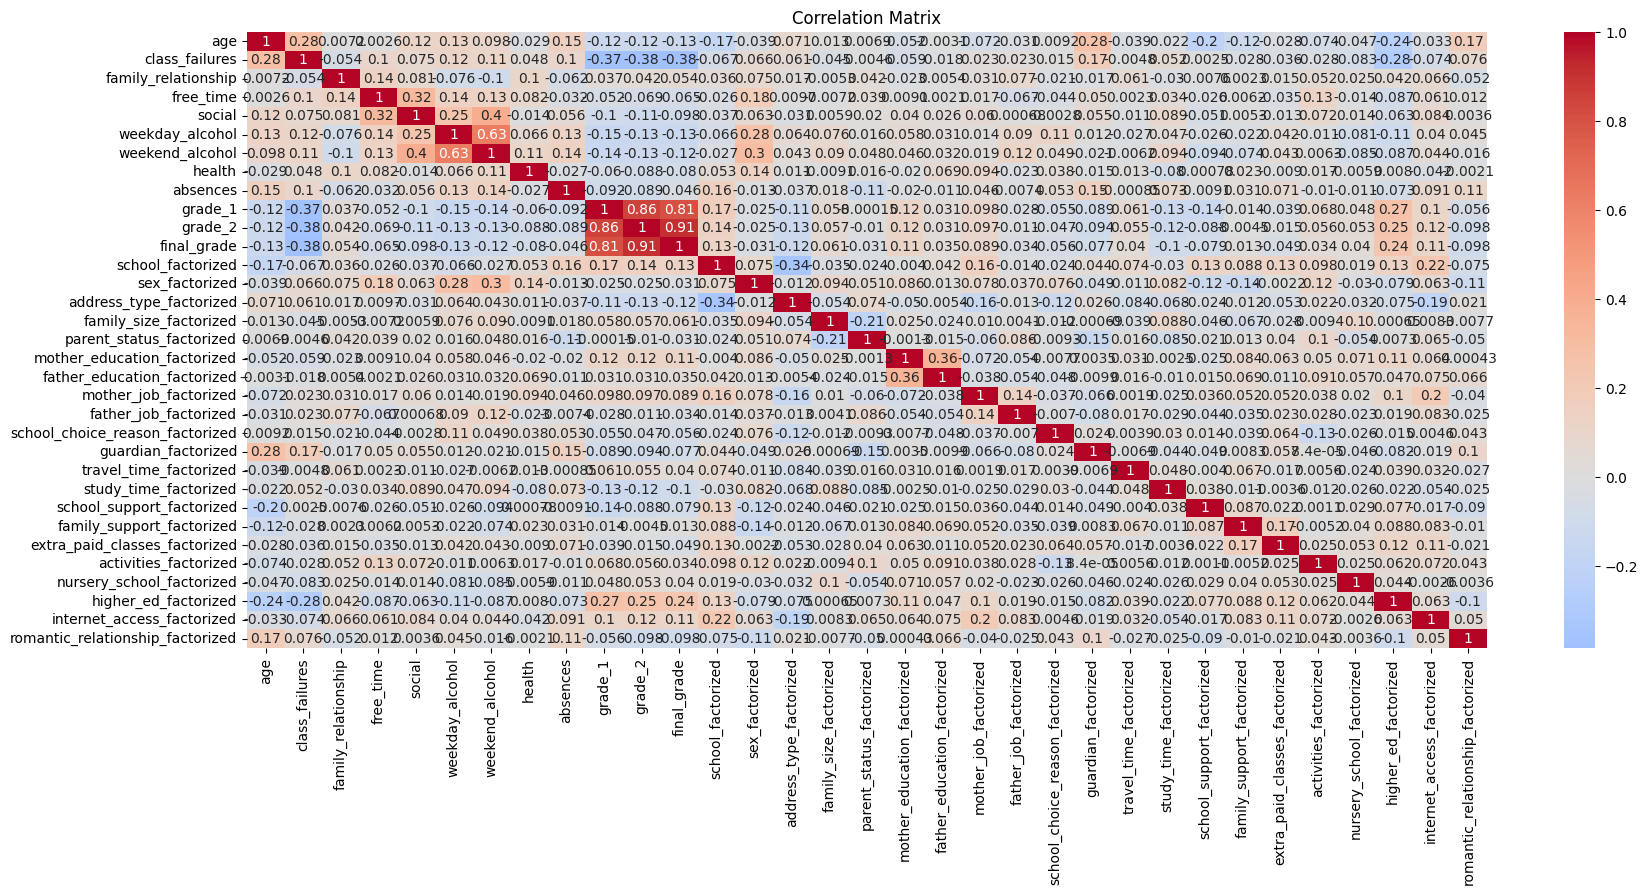

In [ ]:

def visualize_corr():
  pandas_df = df_uni.toPandas()
  corr_matrix = pandas_df.corr()
  # Step 4: Plot the correlation map using seaborn
  plt.figure(figsize=(20, 8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
  plt.title('Correlation Matrix')
  plt.show()

visualize_corr()

In [ ]:
df_uni.columns[12]

'school_factorized'

In [ ]:
# Get the list of columns to drop
columns_to_drop = df_uni.columns[12:]
print(*columns_to_drop)
# # Drop the columns from df_uni
df_uni = df_uni.drop(*columns_to_drop)
df_uni.show()

school_factorized sex_factorized address_type_factorized family_size_factorized parent_status_factorized mother_education_factorized father_education_factorized mother_job_factorized father_job_factorized school_choice_reason_factorized guardian_factorized travel_time_factorized study_time_factorized school_support_factorized family_support_factorized extra_paid_classes_factorized activities_factorized nursery_school_factorized higher_ed_factorized internet_access_factorized romantic_relationship_factorized
+---+--------------+-------------------+---------+------+---------------+---------------+------+--------+-------+-------+-----------+
|age|class_failures|family_relationship|free_time|social|weekday_alcohol|weekend_alcohol|health|absences|grade_1|grade_2|final_grade|
+---+--------------+-------------------+---------+------+---------------+---------------+------+--------+-------+-------+-----------+
| 18|             0|                  4|        3|     4|              1|            

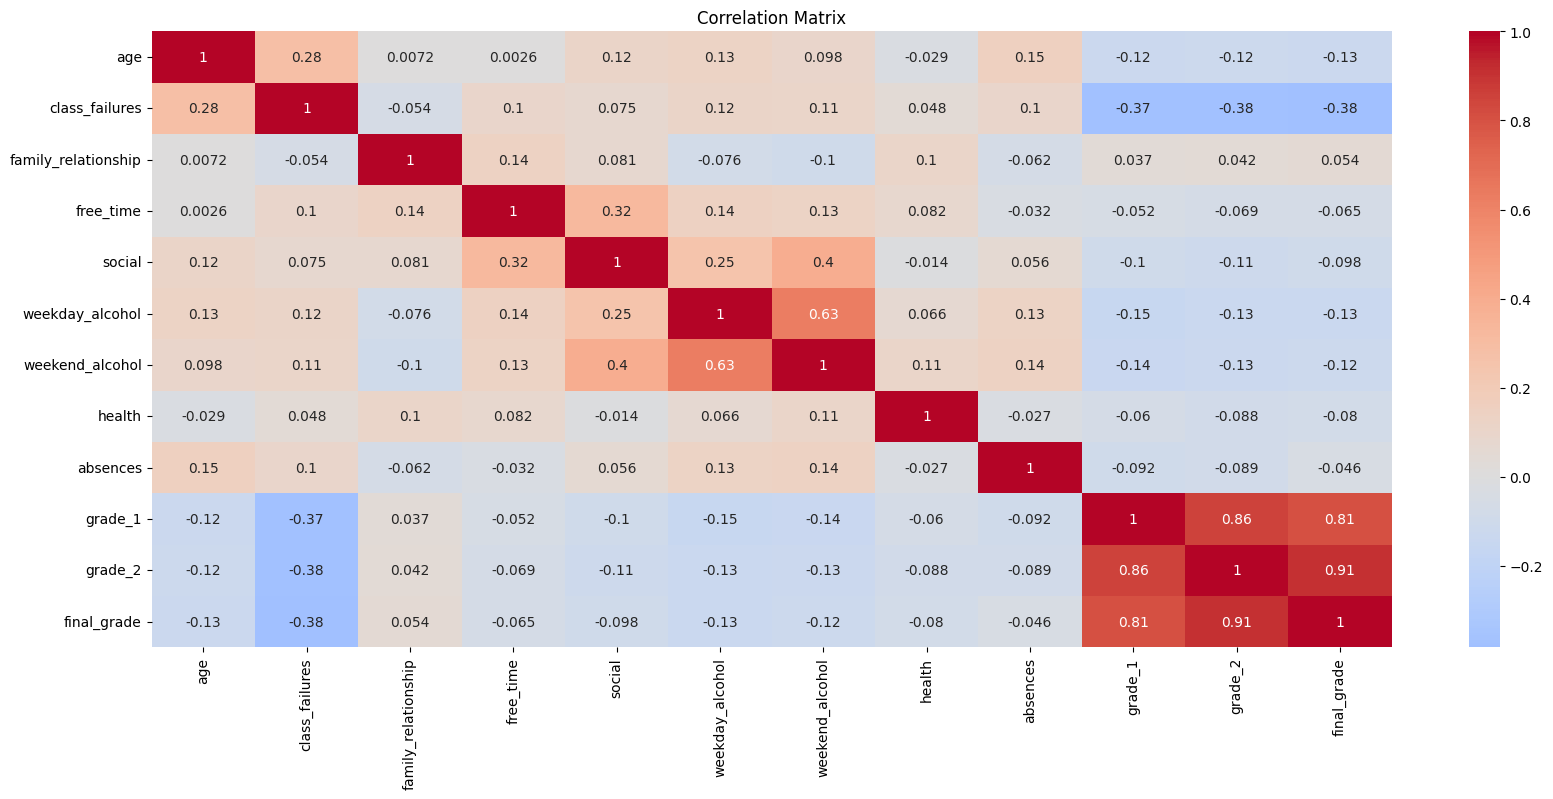

In [ ]:
visualize_corr()

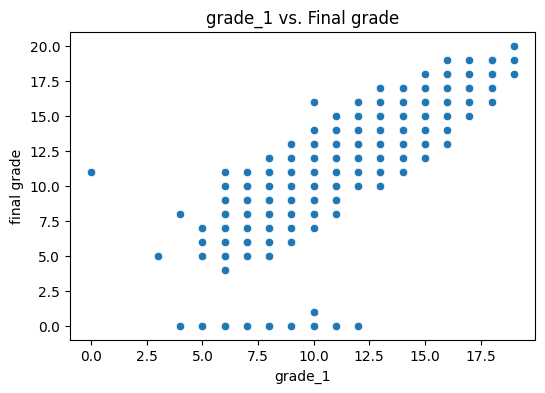

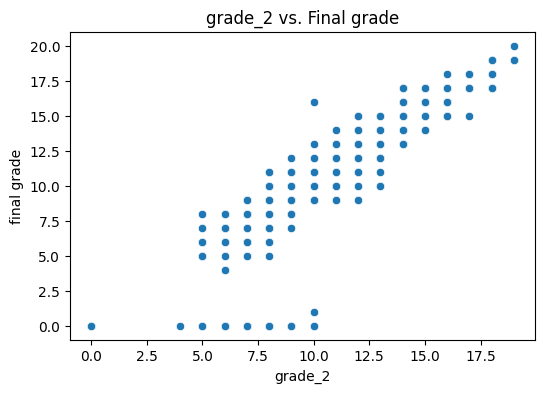

In [ ]:
def visualize_features_vs_target():
  features = ['grade_1', 'grade_2']
  for feature in features:
      plt.figure(figsize=(6, 4))
      pandas_df = df_uni.toPandas()
      sns.scatterplot(x=pandas_df[feature], y=pandas_df['final_grade'])
      plt.title(f'{feature} vs. Final grade')
      plt.xlabel(feature)
      plt.ylabel('final grade')
      plt.show()

visualize_features_vs_target()

##6. Lựa chọn thuộc tính
- nhận thấy Correlation của weekenday-alcohol & weekend_alcohol cao
- correlation của grade_1 & grade_2 với final_grade cao



1.   Do target ban đầu lựa chọn là final_grade, cho nên sẽ bỏ cặp weekenday-alcohol & weekend_alcohol
2.   Ta quyết định lấy 2 features là **grade1** & **grade2**



In [ ]:
selected_columns = ['grade_1', 'grade_2', 'final_grade']
df_selected = df_uni.select(*selected_columns)

# Splitting the data into training and testing sets (80% train, 20% test)
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed=42)
train_data.show(5)
test_data.show(5)

+-------+-------+-----------+
|grade_1|grade_2|final_grade|
+-------+-------+-----------+
|      3|      5|          5|
|      4|      0|          0|
|      5|      0|          0|
|      5|      5|          5|
|      5|      5|          6|
+-------+-------+-----------+
only showing top 5 rows

+-------+-------+-----------+
|grade_1|grade_2|final_grade|
+-------+-------+-----------+
|      5|      0|          0|
|      5|      6|          6|
|      5|      9|          7|
|      6|      5|          0|
|      6|      5|          6|
+-------+-------+-----------+
only showing top 5 rows



\

##7. Chuẩn bị Model Linear Regression

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import lit, col, sqrt, mean, pow, abs
from pyspark.sql.types import StructType, StructField, FloatType, StringType
import math
import numpy as np

# Initialize Spark session

class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.coefficients = None
        self.cost_history = []

    def fit(self, df, target_col):
        # Add intercept column
        df = df.withColumn("intercept", lit(1.0))

        # Assemble the feature matrix X and target vector y
        feature_cols = [col for col in df.columns if col != target_col]
        num_features = len(feature_cols)

        # Initialize coefficients
        self.coefficients = [0.0] * num_features

        for iteration in range(self.n_iterations):
            # Tính predictions Tại lần iteration
            predictions = df.rdd.map(lambda row: self.predict_row(row, feature_cols))
            # Tính ra bộ đạo hàm w1,w2
            gradients = df.rdd.zip(predictions) \
                .map(lambda row_pred: self.compute_gradients(row_pred, feature_cols, target_col)) \
                .reduce(lambda a, b: [x + y for x, y in zip(a, b)])
            #update
            #w1=w1- learning_rate * đạo_hàm(w1)
            #w2=w2- learning_rate * đạo_hàm(w2)
            self.coefficients = [w - self.learning_rate * g for w, g in zip(self.coefficients, gradients)]
            if iteration % 10 == 0:
                temp = df.rdd.zip(predictions) \
                  .map(lambda my_row: self.cal_error(row_pred=my_row,target_col=target_col))
                df_temp =  temp.toDF(['error'])
                mse = df_temp.select(mean(pow(col("error"), 2))).first()[0]
                print(f"mse at {iteration}: {mse}")

    def cal_error(self,row_pred,target_col):
      row, pred = row_pred
      error = pred - row[target_col]
      return Row(error=error)

    def predict_row(self, row, feature_cols):
        return sum(row[feature_cols[i]] * self.coefficients[i] for i in range(len(feature_cols))) # 1 con so sum

    def compute_absolute_error(self, row_pred, target_col):
        row, pred = row_pred
        error = pred - row[target_col]
        return float(error)

    def compute_gradients(self, row_pred, feature_cols, target_col):
        row, pred = row_pred
        error = pred - row[target_col]
        return [error * row[feature_cols[i]] for i in range(len(feature_cols))]

    def calculate_cost(self, df, target_col,feature_cols):
        squared_errors = df.rdd.map(lambda row: (self.predict_row(row, feature_cols) - row[target_col]) ** 2)
        mean_squared_error = squared_errors.mean()
        return mean_squared_error


    # def predict(self,df):
    def __calculate_metrics(self,df):
      df = df.withColumn("residual", col("final_grade") - col("predictions"))
      # Calculate MSE
      mse = df.select(mean(pow(col("residual"), 2))).first()[0]

      # Calculate RMSE
      rmse = math.sqrt(mse)
      # Calculate MAE
      mae = df.select(mean(abs(col("residual")))).first()[0]
      # Calculate ME
      me = df.select(mean(col("residual"))).first()[0]
      # Collect the results
      metrics = {
          "RMSE": rmse,
          "MAE": mae,
          "MSE": mse,
          "ME": me
      }
      return metrics

    def predict(self, df,featureNames = []):
        # Start with the intercept
        prediction_expr = lit(self.coefficients[-1])

        # Iterate through the features and coefficients
        for i, feature in enumerate(featureNames):
            prediction_expr += df[feature] * lit(self.coefficients[i])

        # Add the predictions column to the DataFrame
        df_with_predictions = df.withColumn("predictions", prediction_expr)
        metrics = self.__calculate_metrics(df_with_predictions)
        return [df_with_predictions,metrics]

##8. Training cho data và bắt đầu predict

In [ ]:

print(type(train_data))

my_df = train_data.select('grade_1','grade_2','final_grade')
my_df.show()
# Initialize the model
model = LinearRegressionGD(learning_rate=0.000008, n_iterations=250)

# Fit the model
model.fit(my_df, "final_grade")



# my_pred_df = df.select('grade_1','grade_2')

# # Make predictions
predictions,metrics = model.predict(my_df,['grade_1','grade_2'])
predictions.show()
print(metrics['MAE'])
print(metrics['MSE'])
print(metrics['RMSE'])
print(metrics['ME'])
# print(model.cost_history)

<class 'pyspark.sql.dataframe.DataFrame'>
+-------+-------+-----------+
|grade_1|grade_2|final_grade|
+-------+-------+-----------+
|      3|      5|          5|
|      4|      0|          0|
|      5|      0|          0|
|      5|      5|          5|
|      5|      5|          6|
|      5|      8|          7|
|      6|      0|          0|
|      6|      0|          0|
|      6|      5|          0|
|      6|      5|          0|
|      6|      5|          0|
|      6|      5|          0|
|      6|      5|          5|
|      6|      5|          5|
|      6|      5|          5|
|      6|      5|          6|
|      6|      5|          6|
|      6|      6|          4|
|      6|      6|          8|
|      6|      7|          0|
+-------+-------+-----------+
only showing top 20 rows

mse at 0: 102.4105115451554
mse at 10: 6.216337790470677
mse at 20: 3.145300830953708
mse at 30: 2.9863050620948544
mse at 40: 2.9288806167276404
mse at 50: 2.883641617012526
mse at 60: 2.8462368362374284
mse at 

In [ ]:
print(metrics['MAE'])
print(metrics['MSE'])
print(metrics['RMSE'])
print(metrics['ME'])

1.6
2.6850000000000005
1.638596960817394
-1.6
